# Regression with Automatic Differentiation in TensorFlow

# Task 1: TensorFlow

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print('Using TensorFlow version:', tf.__version__)
print('Devices available:', tf.config.list_physical_devices())

Using TensorFlow version: 2.3.0
Devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


In [10]:
%matplotlib notebook

# Task 2: Constants

In [2]:
tf.constant([[1,2,3]])

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]])>

In [3]:
tf.convert_to_tensor([[1, 2, 3]])

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]])>

In [4]:
tf.convert_to_tensor([[1,2,3]], dtype = tf.float32)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1., 2., 3.]], dtype=float32)>

In [5]:
tf.convert_to_tensor([[1,2,3]], dtype = tf.float32).numpy()

array([[1., 2., 3.]], dtype=float32)

# Task 3: Variables

In [6]:
tf.Variable([[1,2,3]])

<tf.Variable 'Variable:0' shape=(1, 3) dtype=int32, numpy=array([[1, 2, 3]])>

In [7]:
v = tf.Variable(1)
print(f"Initial value = {v.numpy()}")
v.assign(2)
print(f"Final Value = {v.numpy()}")

Initial value = 1
Final Value = 2


In [9]:
c = tf.constant(np.random.randn(2,3))
v = tf.Variable(np.random.randn(3,2))

tf.matmul(c,v)

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[-1.15065525, -1.47109211],
       [ 1.27610094,  2.69260869]])>

# Task 4: Automatic Differentiation

Let's take a simple equation as an example:
\begin{equation}
y = x^3 ; \frac{dy}{dx} = 3x^2
\end{equation}

In [11]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    y = x**3
    
dy_dx = tape.gradient(y, x)
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=27.0>

What about higher order gradients?

\begin{equation}
y = x^3 ; \frac{dy}{dx} = 3x^2 ; \frac{d^2 y}{dx^2} = 6x
\end{equation}

In [12]:
x = tf.Variable(3.0)

with tf.GradientTape() as t1:
    with tf.GradientTape() as t2:
        y = x**3
        
    dy_dx = t2.gradient(y, x) # this operation is still being watched in the context of tape t1
    
d2y_dx2 = t1.gradient(dy_dx, x)

print(f"dy_dx of x**3 at x = 3 is : {dy_dx}")
print(f"d2y_dx2 of x**3 at x = 3 is : {d2y_dx2}")

dy_dx of x**3 at x = 3 is : 27.0
d2y_dx2 of x**3 at x = 3 is : 18.0


# Task 5: Watching Tensors

In [13]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
    y = x**3
    
dy_dx = tape.gradient(y, x)
print(dy_dx)

None


In [14]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**3
    
dy_dx = tape.gradient(y, x)
print(dy_dx)

tf.Tensor(27.0, shape=(), dtype=float32)


# Task 6: Persistent Tape

\begin{equation}
y = x^3 ; z = 2y ; \frac{dz}{dx} = \frac{dz}{dy} . \frac{dy}{dx}
\end{equation}

In [17]:
x = tf.Variable(3.0)

with tf.GradientTape(persistent = True) as tape:
    # as RuntimeError: GradientTape.gradient can only be called once on non-persistent tapes.
    y = x**3
    z = 2 * y
    
dz_dy = tape.gradient(z, y)
dy_dx = tape.gradient(y, x)

print(f"dz_dy * dy_dx : {dz_dy * dy_dx}")

dz_dx = tape.gradient(z, x)

print(f"dz_dx = {dz_dx}")

del tape

dz_dy * dy_dx : 54.0
dz_dx = 54.0


# Task 7: Generating Data for Linear Regression

Solve a simple linear equation:

\begin{equation}
y = wx + b
\end{equation}

In [23]:
true_w, true_b = 7.0, 4.0

def create_batch(batch_size = 64):
    x = np.random.randn(batch_size, 1)
    y = np.random.randn(batch_size, 1) + true_w * x + true_b
    
    return x, y

<IPython.core.display.Javascript object>


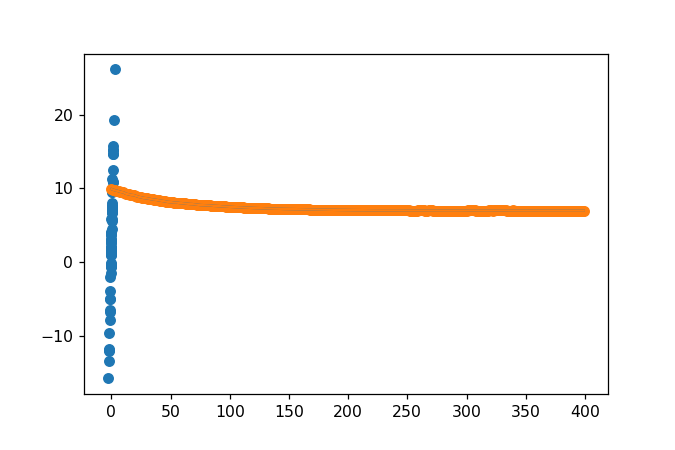

In [25]:
%matplotlib notebook
x, y = create_batch()
plt.figure()
plt.scatter(x, y);

# Task 8: Linear Regression

In [32]:
iterations = 400
lr = 0.01

w = tf.Variable(10.0)
b = tf.Variable(18.0)

w_history, b_history, loss_history = [], [], []

for i in range(iterations):
    x_batch, y_batch = create_batch()
    
    x_batch = tf.convert_to_tensor(x_batch, dtype = tf.float32)
    y_batch = tf.convert_to_tensor(y_batch, dtype = tf.float32)
    
    with tf.GradientTape(persistent = True) as tape:
        y = w * x_batch + b
        loss = tf.reduce_mean(tf.square(y - y_batch))
        
    dw = tape.gradient(loss, w)
    db = tape.gradient(loss, b)
    
    del tape
    
    w.assign_sub(lr * dw)
    b.assign_sub(lr * db)
    
    w_history.append(w.numpy())
    b_history.append(b.numpy())
    loss_history.append(loss.numpy())
    
    if i%50 == 0:
        print(f"Iter = {i}, w = {w.numpy()}, b = {b.numpy()}, loss = {loss.numpy()}")

Iter = 0, w = 9.92175006866455, b = 17.71990394592285, loss = 209.39698791503906
Iter = 50, w = 8.154762268066406, b = 9.007048606872559, loss = 27.451004028320312
Iter = 100, w = 7.518502235412598, b = 5.825502395629883, loss = 4.388745307922363
Iter = 150, w = 7.2178568840026855, b = 4.689772605895996, loss = 1.4142019748687744
Iter = 200, w = 7.082483768463135, b = 4.253843307495117, loss = 1.0409191846847534
Iter = 250, w = 7.02638578414917, b = 4.08636999130249, loss = 1.1662683486938477
Iter = 300, w = 7.016048431396484, b = 4.018455982208252, loss = 0.9054201245307922
Iter = 350, w = 7.011170864105225, b = 4.001217365264893, loss = 0.7796490788459778


<IPython.core.display.Javascript object>


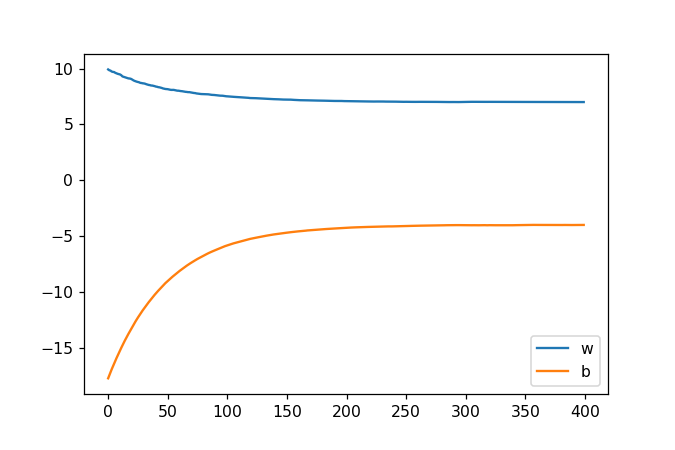

In [42]:
plt.figure()

plt.plot(np.arange(iterations), w_history, label = 'w')
plt.plot(np.arange(iterations), -np.array(b_history), label = 'b')
# plt.plot(np.arange(iterations), loss_history, label = 'loss')
plt.legend()